In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *



2024-01-27 08:17:52.264395: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 08:17:53.072995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-27 08:17:53.073081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-27 08:17:53.073089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [10]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging'


# recursively walk through subdirs to load all the data into a nested dict
data = {}
for model_type in ['pcnn', 'gaussian']:
    data[model_type] = {}
    for object_type in os.listdir(os.path.join(data_path, model_type)):
        data[model_type][object_type] = {}
        for lens_type in os.listdir(os.path.join(data_path, model_type, object_type)):
            data[model_type][object_type][lens_type] = {}
            for mean_photons in os.listdir(os.path.join(data_path, model_type, object_type, lens_type)):
                data[model_type][object_type][lens_type][int(mean_photons.split('_')[0])] = {}
                for background_photons in os.listdir(os.path.join(data_path, model_type, object_type, lens_type, mean_photons)):
                    data[model_type][object_type][lens_type][int(mean_photons.split('_')[0])][int(background_photons.split('_')[0])] = {}
                    files = os.listdir(os.path.join(data_path, model_type, object_type, lens_type, mean_photons, background_photons))
                    patch_sizes = [int(f.split('_')[-2]) for f in files]
                    for patch_size in onp.unique(patch_sizes):
                        # load all data with this patch size
                        patch_size_files = [f for f in files if f.split('_')[-2] == str(patch_size)]
                        data[model_type][object_type][lens_type][int(mean_photons.split('_')[0])][int(background_photons.split('_')[0])][patch_size] = \
                            [np.load(os.path.join(data_path, model_type, object_type, lens_type, mean_photons, background_photons, f)) for f in patch_size_files]

# print the recursive structure of keys
for model_type in data.keys():
    print(model_type)
    for object_type in data[model_type].keys():
        print('  ', object_type)
        for lens_type in data[model_type][object_type].keys():
            print('    ', lens_type)
            for mean_photons in data[model_type][object_type][lens_type].keys():
                print('      ', mean_photons, 'mean photons')
                for background_photons in data[model_type][object_type][lens_type][mean_photons].keys():
                    print('        ', background_photons, 'background photons')
                    for patch_size in data[model_type][object_type][lens_type][mean_photons][background_photons].keys():
                        # print XX replicats at YYY patch size
                        print('          ', len(data[model_type][object_type][lens_type][mean_photons][background_photons][patch_size]), 'replicates at', patch_size, 'patch size')


pcnn
   2_plane_lung
     many_lens
       400 mean photons
         50 background photons
           5 replicates at 80 patch size
     single_lens
       400 mean photons
         50 background photons
           5 replicates at 80 patch size
     double_lens
       400 mean photons
         50 background photons
           5 replicates at 80 patch size
gaussian
   2_plane_lung
     many_lens
       400 mean photons
         50 background photons
           5 replicates at 80 patch size
     single_lens
       400 mean photons
         50 background photons
           5 replicates at 80 patch size
     double_lens
       400 mean photons
         50 background photons
           5 replicates at 80 patch size


In [21]:
def make_plot(background, photons_per_pixel, patch_size, sample):
    single_lens_pcnn_data = data['pcnn'][sample]['single_lens'][photons_per_pixel][background][patch_size]
    double_lens_pcnn_data = data['pcnn'][sample]['double_lens'][photons_per_pixel][background][patch_size]
    many_lens_pcnn_data = data['pcnn'][sample]['many_lens'][photons_per_pixel][background][patch_size]

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
    ax.plot(single_lens_pcnn_data, 'o', label='single lens')
    # plot a dotted line at the min value
    ax.axhline(onp.min(single_lens_pcnn_data), linestyle='--', color=get_color_cycle()[0])
    ax.plot(double_lens_pcnn_data, 'o', label='double lens')
    ax.axhline(onp.min(double_lens_pcnn_data), linestyle='--', color=get_color_cycle()[1])
    ax.plot(many_lens_pcnn_data, 'o', label='many lens')
    ax.axhline(onp.min(many_lens_pcnn_data), linestyle='--', color=get_color_cycle()[2])
    ax.legend()
    ax.set(ylim=(0, None), xlabel='replicate', ylabel='bits per pixel')
    clear_spines(ax)
    ax.set(title=f'{sample} PCNN, {photons_per_pixel} photons/pixel\n{background} background, {patch_size} patch')

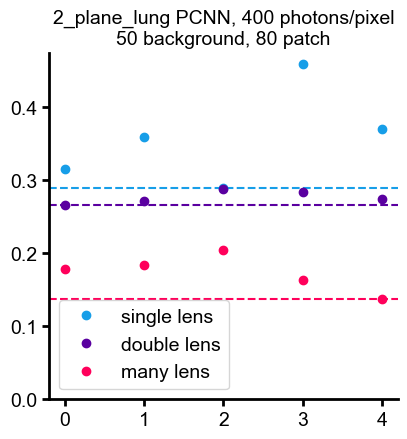

In [22]:
background = 50
photons_per_pixel = 400
patch_size = 80
sample = '2_plane_lung'


make_plot(background, photons_per_pixel, patch_size, sample)